In [1]:
from wodparser import wodparser
from bs4 import BeautifulSoup
import requests

import pandas as pd
import sys
import re

In [5]:
dates = pd.date_range(start='1/1/2009', end='1/10/2009')
wp = wodparser.WodParser(dates)

C:\Users\Asus\Documents\Python Scripts\crossfit_wod\wodparser\wodparser.py:22: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 22 of the file C:\Users\Asus\Documents\Python Scripts\crossfit_wod\wodparser\wodparser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(data)


Parsing 100.0%

In [7]:
wp.wods_raw

{'2009/01/01': '"Murph"For time:\n1 mile Run\n100 Pull-ups\n200 Push-ups\n300 Squats\n1 mile Run',
 '2009/01/02': 'With a continuously running clock do one 135 pound Clean and Jerk the first minute, two 135 pound Clean and Jerks the second minute, three 135 pound Clean and Jerks the third minute... continuing as long as you are able.Use as many sets each minute as needed.',
 '2009/01/04': 'Deadlift 3-3-3-3-3 repsPost loads to comments.',
 '2009/01/05': 'Hang power clean 1-1-1-1-1-1-1 repsPost loads to comments.',
 '2009/01/06': 'Complete four rounds for time:\nRun 400 meters\n15 Handstand Push-ups\n15 ft Rope Climb, 2 ascentsPost time to comments.',
 '2009/01/08': 'Ten rounds for time of:\n3 Weighted Pull-ups, 45 pounds\n5 Strict Pull-ups\n7 Kipping Pull-upFor weighted pull-ups place a 45 pound dumbbell between the legs above crossed ankles and jettison the dumbbell after third rep and continue with strict pull-ups and then the kipping pull-ups. Coming off the bar or going to ground co

In [401]:
def get_wods(dates):
    wods = {}
    n_dates = len(dates)
    failed_dates = []
    for i, da in enumerate(dates):
        url = r'https://www.crossfit.com/workout/%s' % da.strftime('%Y/%m/%d')
        
        r  = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data)
        x = soup.find_all('div', {"class":'content'})
        try:
            wod = x[0].select('p')[0].get_text() + x[0].select('p')[1].get_text()
            if x[0].select('p')[0].get_text() != 'Rest Day':       
                wods[da.strftime('%Y/%m/%d')] = wod
        except:
            try:
                x = soup.find_all('div', {"class":'_6zX5t4v71r1EQ1b1O0nO2 jYZW249J9cFebTPrzuIl0'})
                wod = x[0].select('p')[0].get_text() + x[0].select('p')[1].get_text()
                if x[0].select('p')[0].get_text() != 'Rest Day':       
                    wods[da.strftime('%Y/%m/%d')] = wod
            except:
                print('\nSomething did not work for %s' % da.strftime('%Y/%m/%d'))
                failed_dates.append(da.strftime('%Y/%m/%d'))
        
        sys.stdout.write("\rParsing %4.1f%%" % ((i+1)/n_dates * 100))
    
    return wods, failed_dates
        
wods_raw, failed_dates = get_wods(dates)   

Parsing 23.2%
Something did not work for 2012/04/14
Parsing 47.6%
Something did not work for 2014/09/07
Parsing 69.0%
Something did not work for 2016/10/14
Parsing 91.4%
Something did not work for 2018/12/27
Parsing 91.5%
Something did not work for 2018/12/31
Parsing 94.5%
Something did not work for 2019/04/17
Parsing 100.0%

In [364]:
import json
with open('raw_wod_data.json', 'w') as f:
    json.dump(wods_raw, f)

In [392]:
# wod_regex = '(pull|push|muscle|sit|handstand push)[-]?up[s]?|(front[\s]?|back[\s]?|overhead[\s]?)?squat[s]?|wall[\s]?ball[s]?'
wod_regex1 = '(pull|push|muscle|(ghd\s)?sit|handstand push)[-]?up|(front[\s]?|back[\s]?|overhead[\s]?|single(-|\s)leg[\s]?|one(-|\s)legged[\s]?)?squat(\sclean|\ssnatch)?|wall(-|[\s])?ball|(sumo\s)?dead[\s]?lift'
wod_regex2 = '|(shoulder|push|bench|sots|split)\s(press|jerk)|(hip|back)[\s]?extension|knee[s]?(-|\s)to(-|\s)elbow|sprint|rope\sclimb|dip|swim|bike|handstand\swalk|turkish\sget[-]?up|wall(-|\s)?walk|(kettlebell\sswing)'
wod_regex3 = '|(bent\sover(\sbarbell)?\s)?row|pistol|(power\s|dumbbell\s)?(clean|snatch(es)?)(\sbalance|(\sand\s|\s&\s)jerk)?|(box\s)?step(-|\s)up|(single|double|triple)[-]?under|thruster'
wod_regex4 = '|run|(burpee[\s]?)?(box(-|\s)jump[\s]?)(over)?|(walking\s)?lunge|(broad)[-]?jump|(toes(-|\s)to(-|\s)bar)|plank|l(-|\s)sit'

wod_regex = wod_regex1+wod_regex2+wod_regex3+wod_regex4

wods_clean = {}

for w in wods_raw.keys():
    matches = re.finditer(wod_regex, wods_raw[w], re.MULTILINE | re.IGNORECASE)

    wod_movements = set()
    for matchNum, match in enumerate(matches, start=1):    
        wod_movements.add(match.group().lower())
    
    wod_movements = [mv.replace(' ', '').strip() for mv in wod_movements]
    wod_movements = [mv.replace('-', '').strip() for mv in wod_movements]
    wod_movements = [mv.replace('snatches', 'snatch') for mv in wod_movements]
    wod_movements = [mv.replace('bentoverbarbell', 'bentover') for mv in wod_movements]
    wod_movements = [mv.replace('singlelegsquat', 'pistols') for mv in wod_movements]
    wod_movements = [mv.replace('oneleggedsquat', 'pistols') for mv in wod_movements]
    wod_movements = [mv.replace('&', 'and') for mv in wod_movements]
    wods_clean[w] = wod_movements
#         print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))

# for i in wods_raw.keys():
#     if 'box jump' in wods_raw[i].lower():
#         print(i, wods_raw[i])
#         print()

In [393]:
print(wods_raw['2010/01/17'])

"Fight Gone Bad!"Three rounds of:
Wall-ball, 20 pound ball, 10 ft target (Reps)
Sumo deadlift high-pull, 75 pounds (Reps)
Box Jump, 20" box (Reps)
Push-press, 75 pounds (Reps)
Row (Calories)


In [394]:
wods_clean['2010/01/17']

['boxjump', 'row', 'wallball', 'sumodeadlift']

In [395]:
wods = []

for i in wods_clean.keys():
    if list(wods_clean[i]):
        wods.append(list(wods_clean[i]))

print(len(wods))        

2649


In [396]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [397]:
movement_counter = Counter()
for wod in wods:
    for movement in wod:
        movement_counter[movement] +=1

In [398]:
df = pd.DataFrame(movement_counter.most_common(), columns =['Movement', 'Counts'])
df['Percentage'] = df['Counts'] / len(wods) * 100
df

,Movement,Counts,Percentage
0,pullup,553,20.875802
1,run,473,17.855795
2,deadlift,328,12.382031
3,row,319,12.042280
4,thruster,227,8.569271
5,pushup,212,8.003020
6,squat,201,7.587769
7,muscleup,187,7.059268
8,wallball,186,7.021518
9,handstandpushup,186,7.021518


In [400]:
for k in wods_clean:
    if 'boxstepup' in wods_clean[k]:
        print(k, wods_raw[k])

2019/10/05 For time:200-ft. dumbbell overhead lunge
50 dumbbell box step-ups
50 strict handstand push-ups
200-ft. handstand walk


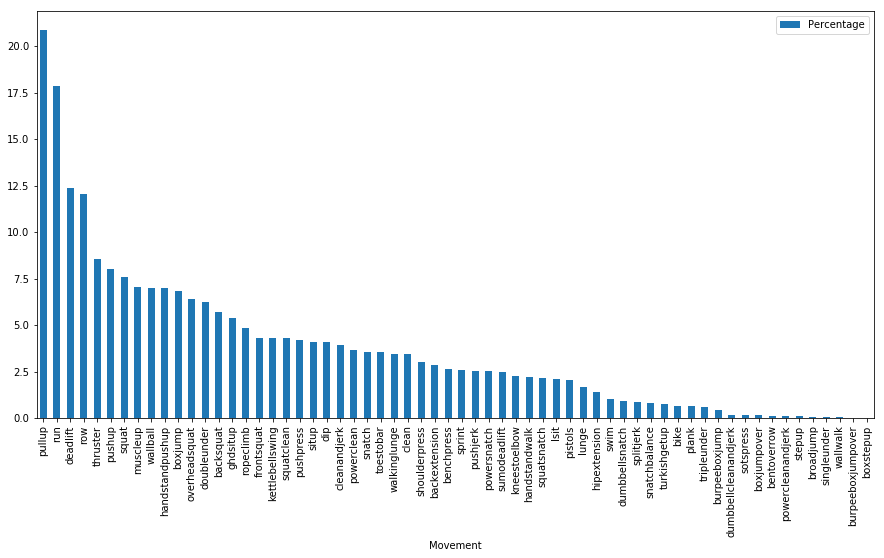

In [399]:
df.plot.bar(x='Movement', y='Percentage', figsize=(15,7.5))

In [371]:
movements = list(movement_counter.keys())

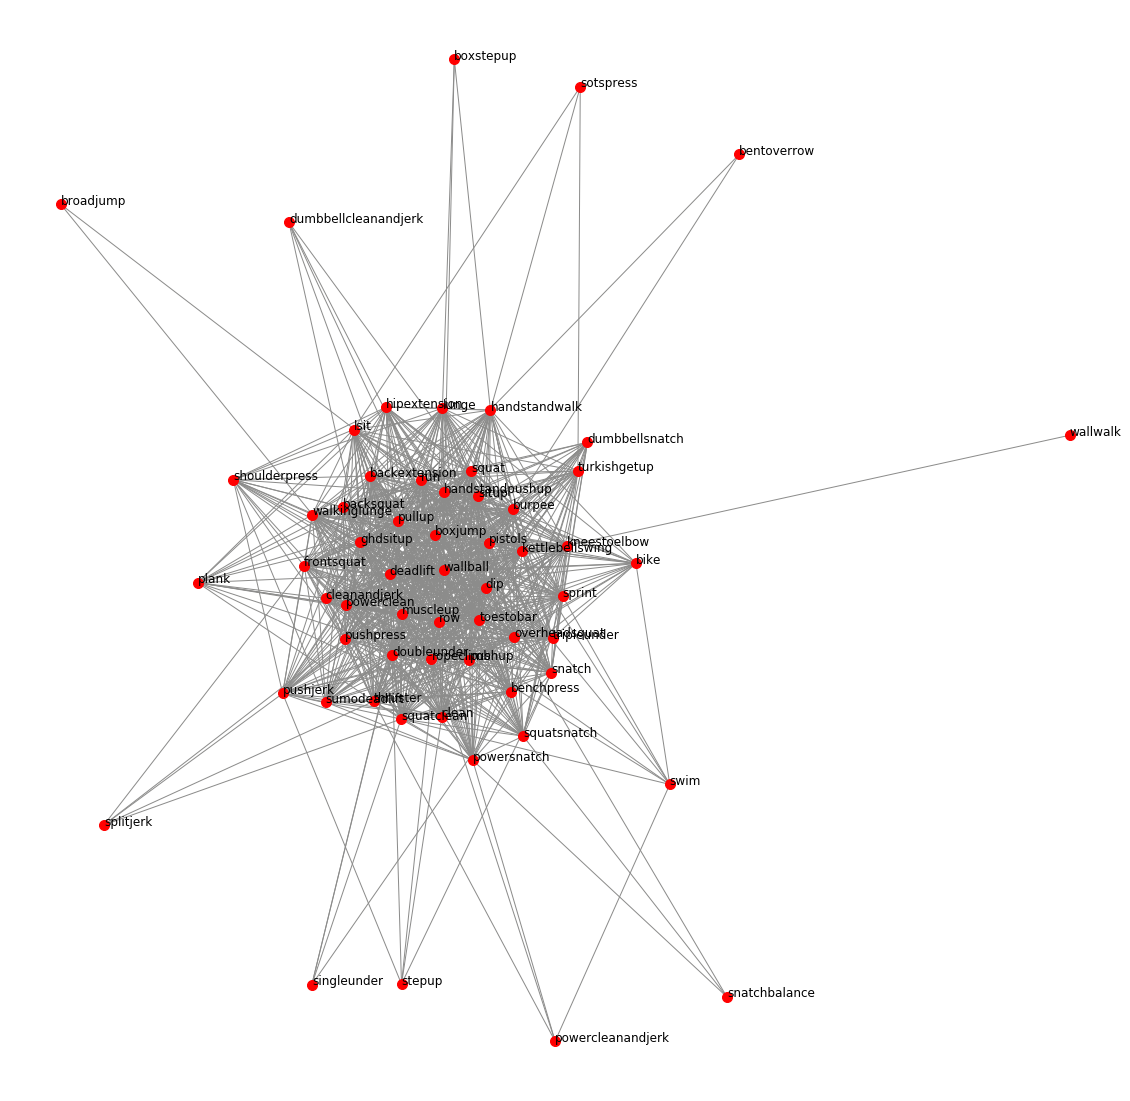

In [372]:
fig, ax = plt.subplots(figsize=(20, 20))
G=nx.Graph()

options = {'node_color': 'red',
           'node_size': 100,
           'width': 1,
           'edge_color': '#8c8c8b'}

    # add nodes
for movement in movements:
    G.add_node(movement)

edges = []
for movement in movements:
    for wod in wods:
        if movement in wod:
            for second_movement in wod:
                if movement != second_movement:
                    edges.append((movement, second_movement))
                    
for edge in edges:
    G.add_edge(edge[0], edge[1])
    
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax, **options)

for i in pos:
    ax.text(pos[i][0], pos[i][1], i, fontsize=12)

# show graph
plt.show()    

In [216]:
G.nodes('pullup')

NodeDataView({'squat': None, 'pullup': None, 'pushup': None, 'situp': None, 'muscleup': None, 'hipextension': None, 'ghdsitup': None, 'run': None, 'wallball': None, 'thruster': None, 'pushjerk': None, 'broadjump': None, 'walkinglunge': None, 'benchpress': None, 'handstandpushup': None, 'boxjump': None, 'row': None, 'deadlift': None, 'burpee': None, 'doubleunder': None, 'backextension': None, 'overheadsquat': None, 'backsquat': None, 'snatchbalance': None, 'snatch': None, 'kneestoelbow': None, 'kettlebellswing': None, 'pushpress': None, 'squatclean': None, 'toestobar': None, 'shoulderpress': None, 'ropeclimb': None, 'frontsquat': None, 'dip': None, 'splitjerk': None, 'handstandwalk': None, 'sprint': None, 'turkishgetup': None, 'lunge': None, 'bike': None, 'sotspress': None, 'bentoverrow': None, 'swim': None, 'singleunder': None, 'wallwalk': None}, data='pullup')

In [304]:
G['thruster']

AtlasView({'squat': {}, 'pullup': {}, 'pushup': {}, 'situp': {}, 'muscleup': {}, 'ghdsitup': {}, 'run': {}, 'wallball': {}, 'powerclean': {}, 'row': {}, 'burpee': {}, 'pushjerk': {}, 'boxjump': {}, 'walkinglunge': {}, 'pushpress': {}, 'doubleunder': {}, 'squatclean': {}, 'toestobar': {}, 'ropeclimb': {}, 'deadlift': {}, 'kettlebellswing': {}, 'handstandpushup': {}, 'kneestoelbow': {}, 'clean': {}, 'sumodeadlift': {}, 'sprint': {}, 'powersnatch': {}, 'overheadsquat': {}, 'backsquat': {}, 'dip': {}, 'frontsquat': {}, 'benchpress': {}, 'snatch': {}, 'backextension': {}, 'cleanandjerk': {}, 'splitjerk': {}, 'powercleanandjerk': {}, 'pistols': {}, 'squatsnatch': {}})

In [310]:
for k in wods_clean:
    if ('thruster' in wods_clean[k]) & ('wallball' in wods_clean[k]):
        print(k, wods_clean[k])
        print(wods_raw[k])
        print()

2012/12/01 ['burpee', 'backsquat', 'situp', 'kettlebellswing', 'overheadsquat', 'wallball', 'boxjump', 'dip', 'ghdsitup', 'pushup', 'sumodeadlift', 'thruster', 'walkinglunge', 'pullup', 'pushpress', 'clean', 'frontsquat', 'kneestoelbow', 'doubleunder', 'deadlift']
For time:
20 Wall ball shots, 20 pound ball
20 Sit-ups
20 Box jump, 24" box
20 Push-ups
135 pound Clean, 20 reps
20 Double-unders
20 Thrusters, 35 pound dumbbells
20 Pull-ups
95 pound Overhead squat, 20 reps
20 Kettlebell swings, 1.5 poods
95 pound Push press, 20 reps
20 Dips
95 pound Sumo deadlift high pull, 20 reps
20 Burpees
135 pound Back squat, 20 reps
20 GHD sit-ups
20 Walking lunge steps
135 pound Deadlift, 20 reps
20 Knees to elbows
135 pound Front squat, 20 repsPost time to comments.

2013/09/11 ['burpee', 'situp', 'kettlebellswing', 'deadlift', 'boxjump', 'wallball', 'thruster', 'pullup', 'kneestoelbow', 'doubleunder']
"The Don"For time:
66 Deadlifts, 110 pounds
66 Box jump, 24 inch box
66 Kettlebell swings, 1.5 poo

In [327]:
4/2440*100

0.16393442622950818

In [373]:
edge_counter = Counter()
for e in edges:
    edge_counter[e] +=1
    
edge_counter.most_common()    

[(('pullup', 'run'), 119),
 (('run', 'pullup'), 119),
 (('pullup', 'pushup'), 117),
 (('pushup', 'pullup'), 117),
 (('squat', 'pushup'), 103),
 (('pushup', 'squat'), 103),
 (('squat', 'pullup'), 100),
 (('pullup', 'squat'), 100),
 (('pullup', 'thruster'), 80),
 (('thruster', 'pullup'), 80),
 (('wallball', 'boxjump'), 77),
 (('boxjump', 'wallball'), 77),
 (('pullup', 'burpee'), 73),
 (('burpee', 'pullup'), 73),
 (('pullup', 'situp'), 65),
 (('situp', 'pullup'), 65),
 (('pullup', 'kettlebellswing'), 62),
 (('kettlebellswing', 'pullup'), 62),
 (('pullup', 'handstandpushup'), 60),
 (('handstandpushup', 'pullup'), 60),
 (('pullup', 'boxjump'), 56),
 (('boxjump', 'pullup'), 56),
 (('boxjump', 'burpee'), 52),
 (('burpee', 'boxjump'), 52),
 (('pullup', 'row'), 49),
 (('pushup', 'situp'), 49),
 (('situp', 'pushup'), 49),
 (('row', 'pullup'), 49),
 (('pullup', 'wallball'), 47),
 (('wallball', 'pullup'), 47),
 (('run', 'burpee'), 46),
 (('burpee', 'run'), 46),
 (('wallball', 'row'), 44),
 (('hand

In [211]:
for e in G.edges:
#     if (e[0] == 'thruster') & (e[1] == 'wallball'):
    print(e[0], e[1])

squat pullup
squat pushup
squat situp
squat muscleup
squat run
squat benchpress
squat overheadsquat
squat handstandpushup
squat row
squat ghdsitup
squat ropeclimb
squat dip
squat snatch
squat backextension
squat walkinglunge
squat pushpress
squat deadlift
squat handstandwalk
squat kettlebellswing
squat toestobar
squat backsquat
squat doubleunder
squat sprint
squat burpee
squat lunge
squat wallball
squat kneestoelbow
squat swim
squat pushjerk
squat snatchbalance
squat boxjump
squat thruster
squat hipextension
squat squatclean
squat bike
squat frontsquat
pullup pushup
pullup situp
pullup wallball
pullup thruster
pullup benchpress
pullup run
pullup burpee
pullup deadlift
pullup handstandpushup
pullup pushjerk
pullup boxjump
pullup walkinglunge
pullup pushpress
pullup muscleup
pullup doubleunder
pullup squatclean
pullup toestobar
pullup row
pullup ghdsitup
pullup frontsquat
pullup kettlebellswing
pullup kneestoelbow
pullup backextension
pullup sprint
pullup snatch
pullup overheadsquat
pull